In [1]:
#It is highly probable that this folder will chnage its name in th future
import sys

sys.path.insert(0, '../../auxiliary_scripts/wavesuite_special')

In [2]:
import os
import numpy as np
import torch

from torch_geometric.data import Data, Dataset

from WaveSuite_graph_functions import build_WaveSuite

In [3]:
import torch_geometric

print(f"Torch version: {torch.__version__}")
print(f"Cuda available: {torch.cuda.is_available()}")
print(f"Torch geometric version: {torch_geometric.__version__}")

Torch version: 1.11.0
Cuda available: True
Torch geometric version: 2.0.4


# Create the list of Data objects where each element is a graph

However, this time is not a list, given that the Dataset was really big it was necessary to create a special class for this Dataset. 

### It was necessary to build the raw data

- The first thing we must do is to read the vtu files, 
- for each one of them extract the feature of interest 
- and then save each step in their own numpy file (or torch but numpy was used instead)

### And then it was necessary to build the processed data

In [4]:
# parent_folder = '../../Datasets/WaveSuite_VTK_fake_copy'    # 'temporal_practice_wavesuite'
parent_folder = '../../../Datasets/WaveSuite_VTK' 
original_folder = parent_folder + '/.'  # Also called orig_dir

features_list = ['nut'] 

original_files_list = os.listdir(original_folder)
original_files_list = [file for file in original_files_list if file[-4:]=='.vtu']

sparse_adjacency_matrix = torch.load('../edges_lists/wave_complete_edge_list.pt')
sparse_adjacency_matrix = sparse_adjacency_matrix.long()

xmin_orig = 0
xmax_orig = 7.2

In [5]:
original_files_list[:4]

['sateNo4_1_40.vtu',
 'sateNo4_1_41.vtu',
 'sateNo4_1_42.vtu',
 'sateNo4_1_43.vtu']

In [6]:
wavesuite_object_train = build_WaveSuite(root=parent_folder, original_files_list=original_files_list, 
                                   features_list=features_list, fixed_edge_index=sparse_adjacency_matrix,
                      xmin_orig = xmin_orig, xmax_orig = xmax_orig , minimum_scaler=0, maximum_scaler=1 ,
                                  test='train' )

RETURN list:  processed_file_names
self.indices() :  range(0, 48)


In [7]:
wavesuite_object_validation = build_WaveSuite(root=parent_folder, original_files_list=original_files_list, 
                                   features_list=features_list, fixed_edge_index=sparse_adjacency_matrix,
                      xmin_orig = xmin_orig, xmax_orig = xmax_orig , minimum_scaler=0, maximum_scaler=1 ,
                                  test='validation' )

RETURN list:  processed_file_names
self.indices() :  range(0, 6)


In [8]:
wavesuite_object_test = build_WaveSuite(root=parent_folder, original_files_list=original_files_list, 
                                   features_list=features_list, fixed_edge_index=sparse_adjacency_matrix,
                      xmin_orig = xmin_orig, xmax_orig = xmax_orig , minimum_scaler=0, maximum_scaler=1 ,
                                  test='test' )

RETURN list:  processed_file_names
self.indices() :  range(0, 6)


In [9]:
wavesuite_object_test

build_WaveSuite(6)

In [10]:
print('wavesuite_object_train.len() : ', wavesuite_object_train.len())
print('wavesuite_object_validation.len() : ', wavesuite_object_validation.len())
print('wavesuite_object_test.len() : ', wavesuite_object_test.len())

wavesuite_object_train.len() :  48
wavesuite_object_validation.len() :  6
wavesuite_object_test.len() :  6


## Create DataLoaders

In [11]:
from torch_geometric.loader import DataLoader

In [12]:
NUM_GRAPHS_PER_BATCH = 8
train_loader = DataLoader(wavesuite_object_train, batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)
validation_loader = DataLoader(wavesuite_object_validation, batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)
test_loader = DataLoader(wavesuite_object_test, batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)

## Let's train some models

In [13]:
from train_top_AE import train_top_AE, evaluate_top_AE , model_MSE_error

In [14]:
#This dictionary stores the losses results of the models
results_models = {}

#These are the models specifications
num_features = 1  #This is always 1
embedding_sequence = None
num_epochs = 20 #Change to 20 and then to 50 

In [15]:
n_points = wavesuite_object_train[0].x.shape[0]  

In [16]:
import time

# Use GPU for training
# preferred_device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
preferred_device = torch.device("cpu")

# from livelossplot import PlotLosses 

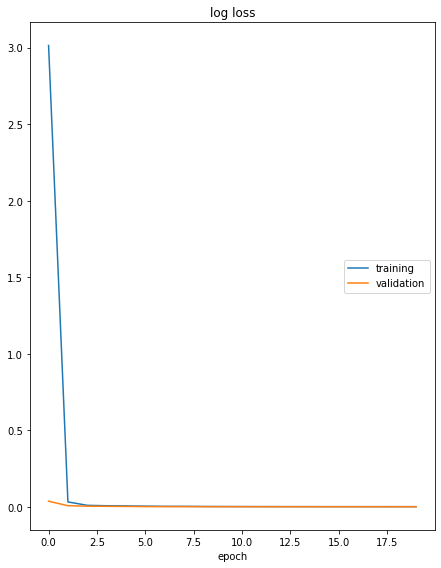

log loss
	training         	 (min:    0.001, max:    3.014, cur:    0.001)
	validation       	 (min:    0.001, max:    0.037, cur:    0.001)

 Number of parameters:  872641949
Time taken:  800.1366541385651


In [17]:
start = time.time()

latent_space_dim = 256

model_name = 'latDim256'

model1, results_models[model_name] = train_top_AE(train_loader, validation_loader, 
                                                n_points, num_features, embedding_sequence=embedding_sequence , 
                                                latent_space_dim=latent_space_dim, ae_model_type='classic_AE_variant1', 
                                                num_epochs=num_epochs, device=preferred_device)

end = time.time()

print('Time taken: ',end-start) 

## MSE results

In [18]:
sys.path.insert(0, '../../auxiliary_scripts')

from rank_models import plot_losses , rank_losses

In [19]:
models_names = list( results_models.keys() )

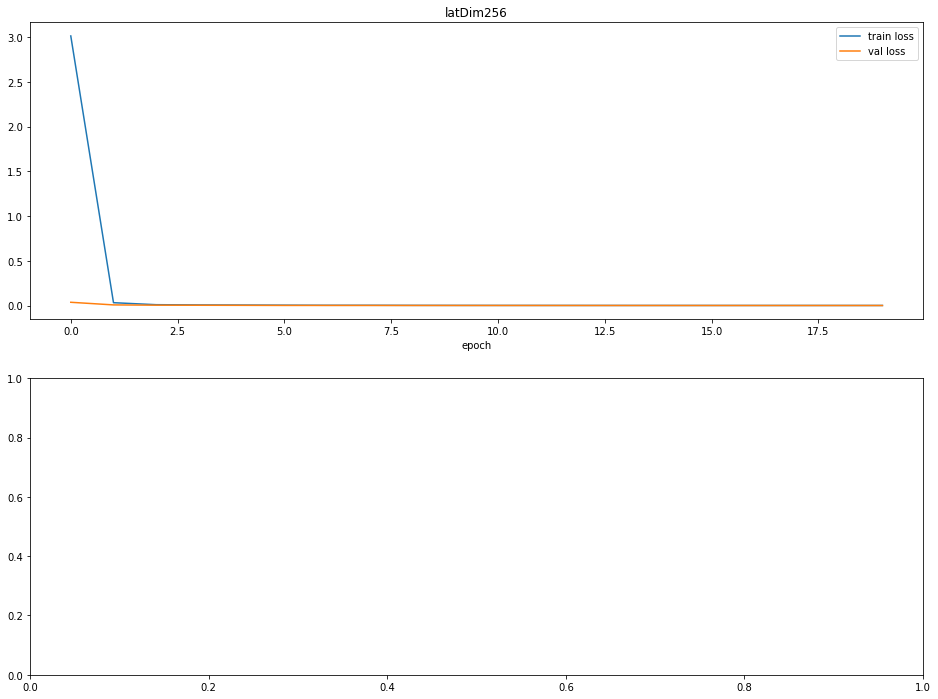

In [20]:
filename = 'classic_AE_variant1_256latDim_WaveSuite'+'.png'
plot_losses(results_models, models_names, figsize=(16,12), filename=filename)

In [21]:
rank_losses(results_models, models_names, selected_epoch = int(num_epochs/4) )

,variants_name,final_validation_loss
0,latDim256,0.002651


In [22]:
rank_losses(results_models, models_names, selected_epoch = int(num_epochs/2) )

,variants_name,final_validation_loss
0,latDim256,0.00116


In [23]:
first_column_model_name = 'classic_AE_variant1_256latDim'
filename = 'final_model_WaveSuite'+'.csv'

df_losses = rank_losses(results_models, models_names, selected_epoch = num_epochs,
                       first_column_model_name = first_column_model_name, filename = filename )

df_losses

CSV was saved


,Model name,variants_name,final_validation_loss
0,classic_AE_variant1_256latDim,latDim256,0.000663


# Plot the results

In [24]:
from plot_results_3D_vtu import compare_three_plots_models_3D_vtu, plot_model_3D_vtu

In [25]:
filename_to_copy_structure = '../../../Datasets/WaveSuite_VTK/sateNo4_1_51.vtu'

Indexes plotted [5 0 4 2 1 3]


C:\Users\angel\Anaconda3\envs\second-try-alienware\lib\site-packages\pyvista\jupyter\notebook.py:60: UserWarning: Failed to use notebook backend: 

Please install `ipyvtklink` to use this feature: https://github.com/Kitware/ipyvtklink

Falling back to a static output.
  warnings.warn(


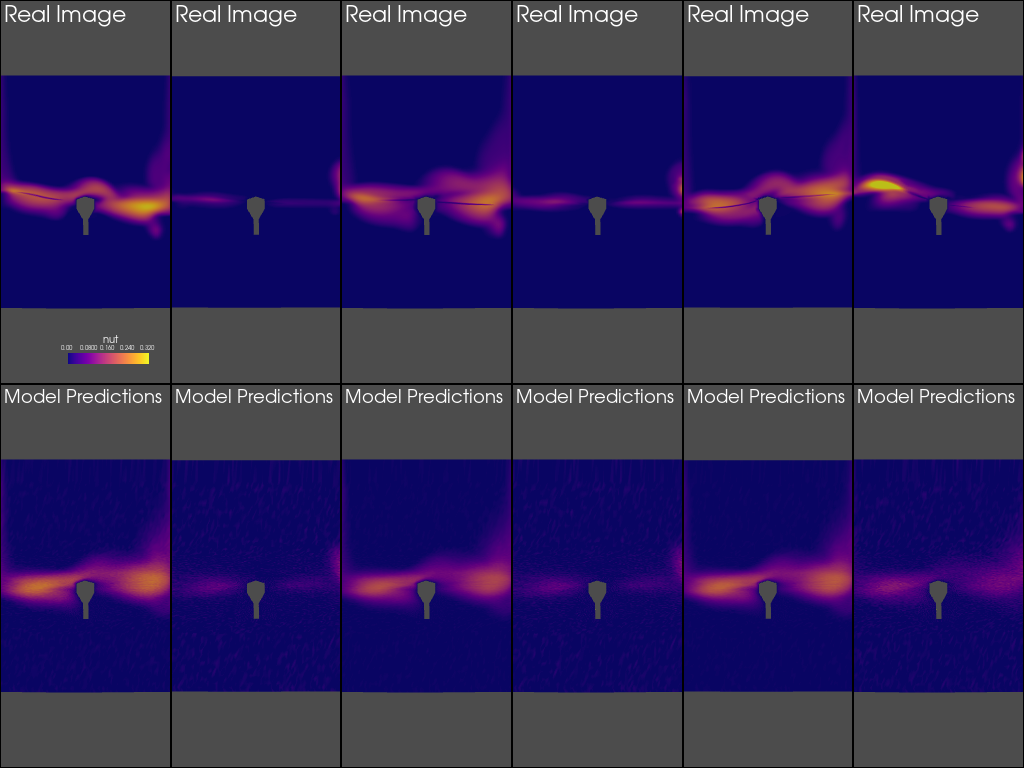

In [26]:
plot_model_3D_vtu(model1, wavesuite_object_test, 6, filename_to_copy_structure, 
                      show_edges=False, random=True, is_data_in_loader=False, 
                      save_fig=True, filename='final_model_WaveSuite.eps')

## Save best models parameters just in case

In [27]:
PATH = 'saved_model_parameters/final_model.pkl'  
torch.save(model1, PATH)

In [28]:
import winsound
from time import sleep

# winsound.PlaySound("SystemExplanation", winsound.SND_ALIAS)
winsound.Beep(440, 500)
sleep(3)
winsound.Beep(440, 500)
sleep(3)
winsound.Beep(440, 500)